In [1]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error

import numpy as np 
import pandas as pd
import xgboost as xgb
import gc
import sys
import os
sys.path.append(os.path.abspath("../../.."))


from Preprocessing.preprocessing_pipeline_impute import preprocessing_pipeline
from Preprocessing.imputation import get_imputation_maps, apply_imputation,ContextImputer
from Preprocessing.preprocessing_pipeline_segment import preprocessing_pipeline_segment
from Preprocessing.split_new import split_data
from utils.eval_call import evaluate_model
from utils.scatter_plot import scatter_prediction


import seaborn as sns
import matplotlib.pyplot as plt

Training XGBoost model...
XGBoost Performance Metrics:
MAE: 4038.35
MSE: 692886528.00
RMSE: 26322.74
R²: 0.67
------------------------------


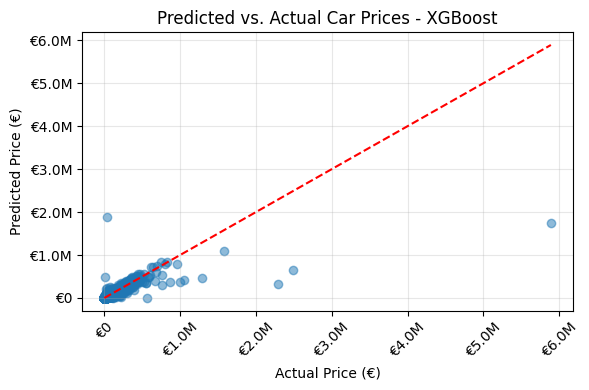

In [2]:
# 1) Daten laden / splitten
X_train, X_test, y_train, y_test, cat_feats, num_feats = split_data('../../../data.csv', segment = True)

# 2) Transformer
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_feats),
    ('cat', categorical_transformer, cat_feats)
])

# 3) XGBoost-Pipeline
xgb_pipeline = Pipeline([
    ('imp_fc', ContextImputer('fuel_consumption_l_100km')),
    ('imp_ps', ContextImputer('power_ps')),
    ('imp_er', ContextImputer('electric_range')),
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

print("Training XGBoost model...")

xgb_pipeline.fit(X_train, y_train)  

y_pred = xgb_pipeline.predict(X_test)
evaluate_model(y_test, y_pred, "XGBoost")
scatter_prediction(y_test, y_pred, "XGBoost")



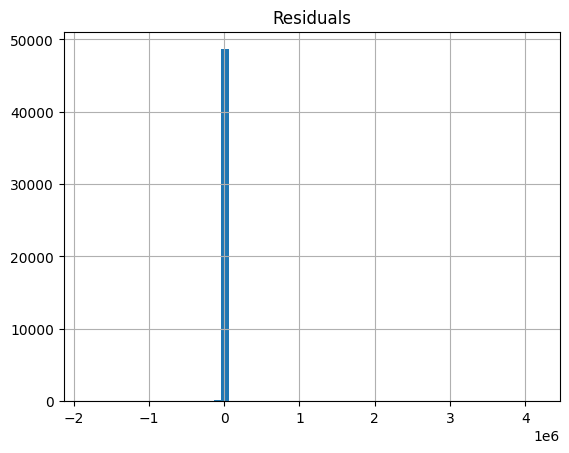

fuel
CNG               3472.793213
Diesel            3654.345215
LPG               3923.397461
Other             4057.901855
Petrol            4098.073242
Diesel Hybrid     5117.788086
Hybrid            5304.075684
Electric          5426.835938
Unknown           9937.203125
Hydrogen         12210.357422
dtype: float64


/var/folders/y9/d279tz1j1k957cycwlj25_6h0000gn/T/ipykernel_63827/2189972824.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: mean_absolute_error(d.y_true, d.y_pred))


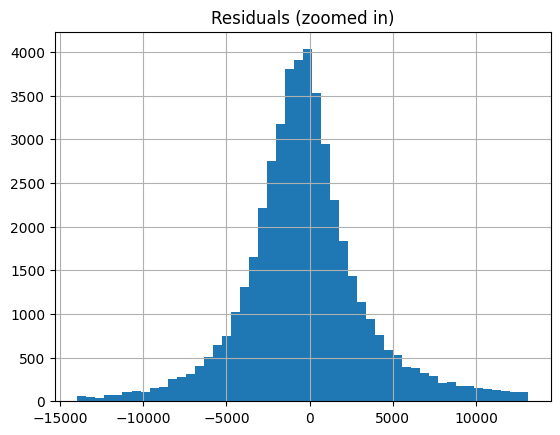

Ausreißer-Anteil: 4.136322723181409 %


In [3]:
results = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'fuel'  : X_test['fuel_type'].values,
    'brand' : X_test['brand'].values,
    'model'  : X_test['model'].values,
    'segment'  : X_test['segment'].values,
})

# 1) Residual Histogram
results['res'] = results.y_true - results.y_pred
results.res.hist(bins=60); plt.title('Residuals'); plt.show()

# 2) MAE nach fuel_type
print(results.groupby('fuel')
    .apply(lambda d: mean_absolute_error(d.y_true, d.y_pred))
    .sort_values())
    # Residuen-Array
res = results.res

# nur Residuen innerhalb ±3*IQR anzeigen
q1, q3 = np.percentile(res, [25, 75])
iqr = q3 - q1
mask = (res > q1 - 3*iqr) & (res < q3 + 3*iqr)

res[mask].hist(bins=50)
plt.title("Residuals (zoomed in)")
plt.show()
print("Ausreißer-Anteil:", (~mask).mean()*100, "%")


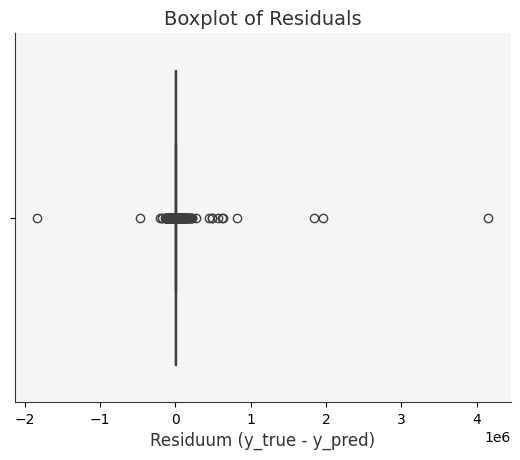

Mean Absolute Error (MAE): 4,038.35
Mean Squared Error (MSE): 692,886,537.56
Root Mean Squared Error (RMSE): 26,322.74


In [4]:
sns.boxplot(data=results, x = 'res')
plt.title("Boxplot der Residuen")
plt.xlabel("Residuum (y_true - y_pred)")
sns.despine()
plt.gca().patch.set_facecolor('#f5f5f5')
plt.gca().spines['bottom'].set_color('#333')
plt.gca().spines['left'].set_color('#333')
plt.xlabel("Residuum (y_true - y_pred)", fontsize=12, color='#333')
plt.title("Boxplot of Residuals", fontsize=14, color='#333')
plt.show()

mae = mean_absolute_error(results['y_true'], results['y_pred'])
print(f"Mean Absolute Error (MAE): {mae:,.2f}")

mse = np.mean((results['y_true'] - results['y_pred'])**2)
print(f"Mean Squared Error (MSE): {mse:,.2f}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")

In [5]:
pd.set_option('display.float_format', lambda x: f'{x:,.0f}')

In [6]:
results.sort_values(by='res', ascending= False)

,y_true,y_pred,fuel,brand,model,segment,res
742,5890500,"1,734,380",Petrol,lamborghini,Lamborghini,Supersportwagen,"4,156,120"
9473,2289000,"333,004",Petrol,aston-martin,Aston Martin,Supersportwagen,"1,955,996"
48780,2490000,"655,425",Petrol,mercedes-benz,Mercedes-Benz SLR,Supersportwagen,"1,834,575"
10746,1288000,"473,682",Petrol,aston-martin,Aston Martin Vantage,Supersportwagen,"814,318"
23977,999999,"374,324",Petrol,mercedes-benz,Mercedes-Benz CLK 55 AMG,Sportwagen,"625,675"
...,...,...,...,...,...,...,...
34531,25299,"206,195",Petrol,jeep,Jeep Gladiator,SUV,"-180,896"
42411,76888,"258,446",Petrol,porsche,Porsche 991,Sportwagen,"-181,558"
39382,32999,"236,776",Petrol,porsche,Porsche 997,Sportwagen,"-203,777"
21053,5499,"481,306",Petrol,mercedes-benz,Mercedes-Benz SLR,Supersportwagen,"-475,807"


<Figure size 1000x600 with 0 Axes>

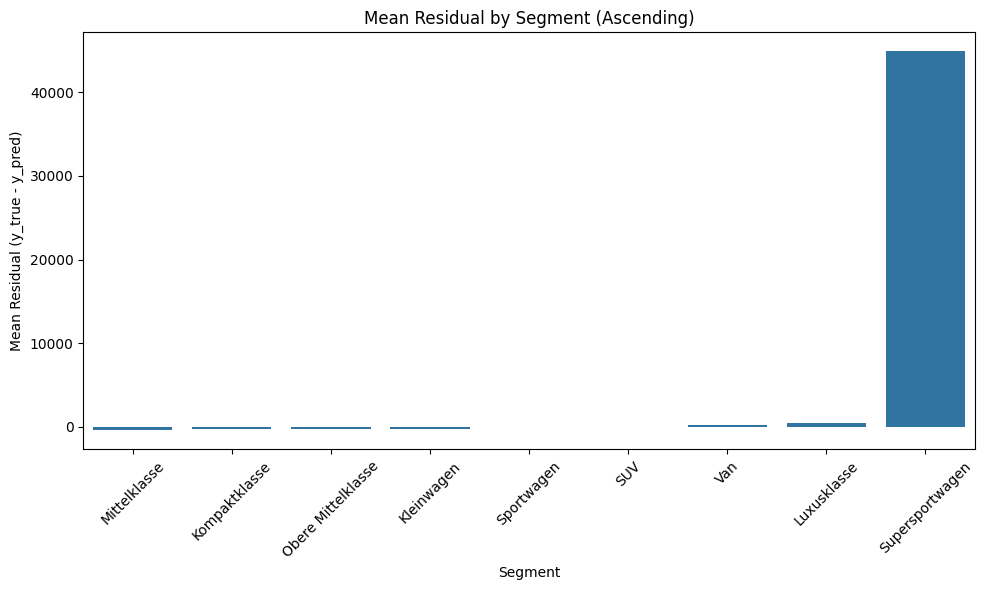

In [7]:
plt.figure(figsize=(10, 6))
mean_res_by_segment = results.groupby('segment')['res'].mean().sort_values()

# Sort bars in ascending order
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_res_by_segment.index, y=mean_res_by_segment.values, order=(mean_res_by_segment.index))
plt.title("Mean Residual by Segment (Ascending)")
plt.xlabel("Segment")
plt.ylabel("Mean Residual (y_true - y_pred)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

-> bei den Sportwagen habe wir den größten durchschnittlichen Fehler dicht gefolgt von der Mittelklasse. Dies spricht dafür, das unser Model die hohen Preisunterschiede bei den Luxusklassen und den Supersportwagen nicht so gut erfassen kann

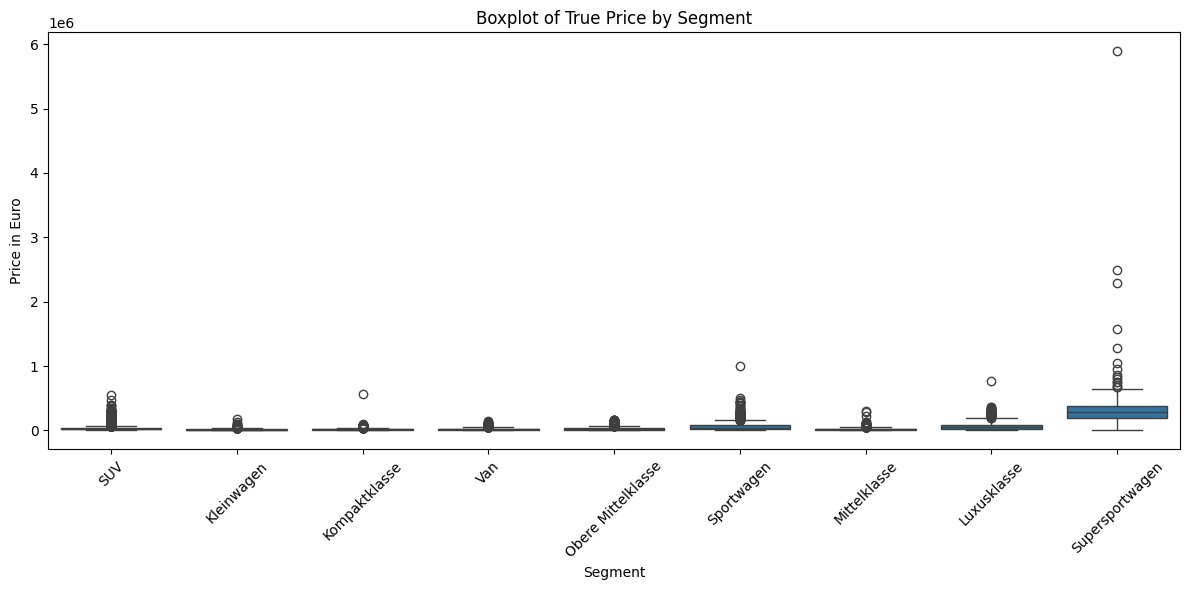

In [8]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=results, x='segment', y='y_true')
plt.title("Boxplot of True Price by Segment")
plt.xlabel("Segment")
plt.ylabel("Price in Euro")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

-> bei der Luxusklasse und bei den Supersportwagen haben wir eine tendenziell höhere Preisspanne was dafür sprechen könnte, dass wir eher overfitten auf den restlichen Segmenten bzw die teureren Segmente nicht so gut abbilden können

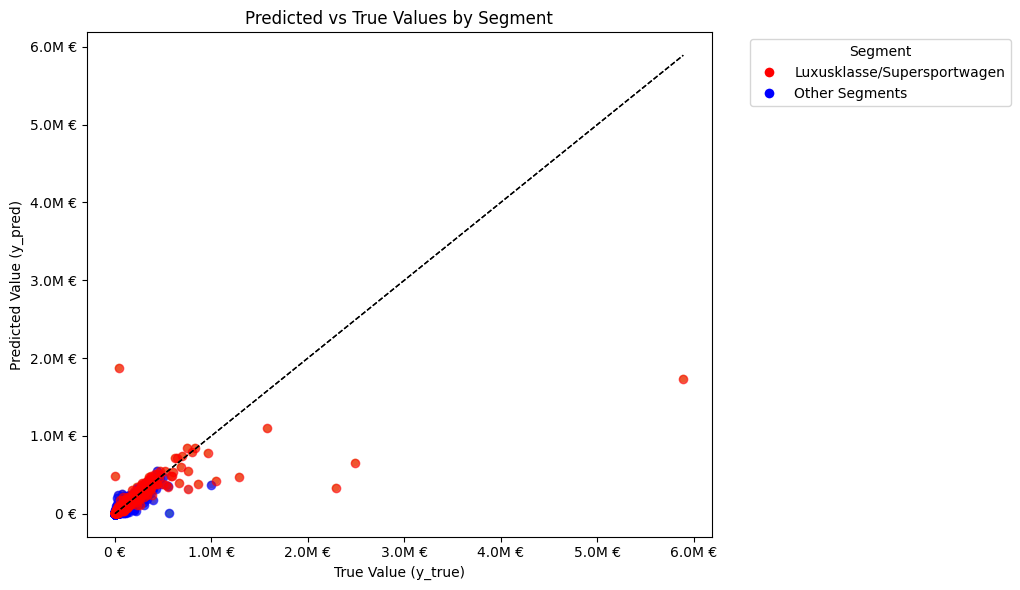

In [9]:
from matplotlib.lines import Line2D

plt.figure(figsize=(10, 6))
sns.scatterplot(data=results, x='y_true', y='y_pred', hue='segment', alpha=0.6, palette='tab10')
plt.plot([results.y_true.min(), results.y_true.max()],
         [results.y_true.min(), results.y_true.max()],
         color='black', linestyle='--', linewidth=1)
plt.xlabel("True Value (y_true)")
plt.ylabel("Predicted Value (y_pred)")
plt.title("Predicted vs True Values by Segment")
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
custom_palette = {'Luxusklasse': 'red', 'Supersportwagen': 'red'}
default_color = 'blue'

# Assign colors: red for the two segments, blue for the rest
results['color'] = results['segment'].map(lambda x: custom_palette.get(x, default_color))

# Plot
for seg in results['segment'].unique():
    subset = results[results['segment'] == seg]
    plt.scatter(subset['y_true'], subset['y_pred'],
                color=custom_palette.get(seg, default_color),
                alpha=0.6, label=seg if seg in custom_palette else None)

# Plot the reference line
plt.plot([results.y_true.min(), results.y_true.max()],
         [results.y_true.min(), results.y_true.max()],
         color='black', linestyle='--', linewidth=1)

# Custom legend: only show the two highlighted segments and "Other"
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Luxusklasse/Supersportwagen', markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Other Segments', markerfacecolor='blue', markersize=8)
]
plt.legend(handles=legend_elements, title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
# Format both axes with thousands separator and Euro sign
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,} €"))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{int(y):,} €"))
import matplotlib.ticker as mticker

def thousands_formatter(x, pos):
    if abs(x) >= 1_000_000:
        return f"{x/1_000_000:.1f}M €"
    elif abs(x) >= 1_000:
        return f"{x/1_000:.0f}k €"
    else:
        return f"{int(x)} €"

plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))
plt.show()